# Task 1: Beat Tracking and Tempo Estimation with Madmom RNN Tracker and GTZAN Dataset

Here we define a function that calculates the beat locations of a track using Madmom's RNN algorithm:

In [1]:
import os
import madmom
import librosa
import soundfile as sf
from madmom.features.beats import BeatTrackingProcessor, RNNBeatProcessor
import numpy as np
import matplotlib.pyplot as plt
import mir_eval
import csv


def madmom_calculate_beats(audio_file_path):
    
    signal, sample_rate = librosa.load(audio_file_path, sr=None) 

    # Tempo estimation
    proc = BeatTrackingProcessor(fps=100)
    act = RNNBeatProcessor()(signal)  # Pass the loaded audio data (audio)
    beats = proc(act)

    tempo_proc = RNNBeatProcessor()
    tempo_beats = tempo_proc(signal)

    # Calculate the tempo from the beats
    tempo_processor = madmom.features.tempo.TempoEstimationProcessor(fps=100)
    tempo = tempo_processor(tempo_beats)[0][0].item()  # Extract the scalar value


    
    return beats, tempo

Functions that read ground truth beat and tempo files to retrieve readable beat and tempo information

In [2]:
def load_beats(file_path):
    with open(file_path, 'r') as file:
        beats = [float(line.split()[0]) for line in file]
    return beats

def load_tempo(file_path):
    with open(file_path, 'r') as file:
        return float(file.read().strip())

We will need to separate the genre and the file number from the audio file name to find the corresponding annotation files

In [3]:
def extract_genre_and_file_number(file_name):
    
    file_parts = os.path.splitext(file_name)[0].split('.')

    if len(file_parts) == 2:
        genre, file_number = file_parts
        return genre, file_number.zfill(5)
    else:
        return None, None


With this function, we will use the Madmom algorithm to estimate beats for each audio file in the GTZAN  

In [43]:
import pandas as pd

def evaluate_beat_tracking_algorithm(algorithm_name, algorithm_beats_folder, ground_truth_beats_folder, ground_truth_tempo_folder):
    genres = os.listdir(algorithm_beats_folder)

    f_measure_data = {}
    
    total_f_measure_sum = 0
    
    acc1_data = {}
    acc2_data = {}
    
    total_acc1_sum = 0
    total_acc2_sum = 0

    total_num_files = 0

    df = []

    for genre in genres:
        genre_path = os.path.join(algorithm_beats_folder, genre)
        if not os.path.isdir(genre_path):
            continue

        genre_files = os.listdir(genre_path)

        num_files = 0

        genre_f_measure_sums = {}
        
        genre_acc1_sums = {}
        genre_acc2_sums = {}
        
        for file_name in genre_files:
            genre_part, file_number = extract_genre_and_file_number(file_name)
            if genre_part is None or file_number is None:
                print(f"Skipping invalid file name: {file_name}")
                continue

            algorithm_audio_path = os.path.join(genre_path, file_name)
            ground_truth_beats_path = os.path.join(ground_truth_beats_folder, f"gtzan_{genre_part}_{file_number}.beats")
            ground_truth_tempo_path = os.path.join(ground_truth_tempo_folder, f"gtzan_{genre_part}_{file_number}.bpm")
            
            if not os.path.isfile(ground_truth_beats_path):
                print(f"Ground truth beats not found for {file_name}")
                continue
            
            if algorithm_name == "madmom":
                algorithm_beats, algorithm_tempo = madmom_calculate_beats(algorithm_audio_path)
            elif algorithm_name == "librosa":
                algorithm_beats, algorithm_tempo = librosa_calculate_beats(algorithm_audio_path)
            else:
                raise Exception("Invalid Algorithm Name")
            
            ground_truth_beats = load_beats(ground_truth_beats_path)

            ground_truth_tempo = load_tempo(ground_truth_tempo_path)

            if algorithm_name == "madmom":
                for i in range(len(algorithm_beats)):
                    algorithm_beats[i] *= 2
                    
            algorithm_beats_array = np.array(algorithm_beats)
            ground_truth_beats_array = np.array(ground_truth_beats)

            reference_beats = mir_eval.beat.trim_beats(ground_truth_beats_array)
            estimated_beats = np.array(mir_eval.beat.trim_beats(algorithm_beats_array))

            f_measure = mir_eval.beat.f_measure(reference_beats, estimated_beats)
            
            accuracy1, accuracy2 = calculate_accuracy(algorithm_tempo, ground_truth_tempo)
            
            print(f"F-measure for {file_name}: {f_measure}")

            genre_f_measure_sums[genre] = genre_f_measure_sums.get(genre, []) + [f_measure]
            
            genre_acc1_sums[genre] = genre_acc1_sums.get(genre, []) + [accuracy1]
            genre_acc2_sums[genre] = genre_acc2_sums.get(genre, []) + [accuracy2]

            print(f"Audio File: {file_name}")
            print(f"Algorithm Beats: {algorithm_beats}")
            print(f"Ground Truth Beats: {ground_truth_beats}")            
    
            print('------------------------------')
            num_files += 1
            
            print(f"Algorithm Tempo: {algorithm_tempo}")
            print(f"Ground Truth Tempo: {ground_truth_tempo}")
            print(f"Acc1 Score: {accuracy1}")
            print(f"Acc2 Score: {accuracy2}")

            properties = {
                'file_name': file_name,
                'genre': genre,
                'f_measure': f_measure,
                'algorithm_tempo': algorithm_tempo,
                'ground_truth_tempo': ground_truth_tempo,
                'accuracy_1': accuracy1,
                'accuracy_2': accuracy2
            }

            df.append(properties)
            print('data-collection size: ', len(df))

        if num_files > 0:
            print(f'Genre: {genre}')
            print(f'Num Files: {num_files}')
        print('------------------------------')
            
        for genre, f_measure_sum in genre_f_measure_sums.items():
            genre_average = sum(f_measure_sum) / num_files
            f_measure_data[genre] = genre_average
            total_f_measure_sum += sum(f_measure_sum)
            
        for genre, acc1_sum in genre_acc1_sums.items():
            genre_average = sum(acc1_sum) / num_files
            acc1_data[genre] = genre_average
            total_acc1_sum += sum(acc1_sum)
            
        for genre, acc2_sum in genre_acc2_sums.items():
            genre_average = sum(acc2_sum) / num_files
            acc2_data[genre] = genre_average
            total_acc2_sum += sum(acc2_sum)

        total_num_files += num_files

    f_measure_data["overall"] = total_f_measure_sum / total_num_files
    
    acc1_data["overall"] = total_acc1_sum / total_num_files
    acc2_data["overall"] = total_acc2_sum / total_num_files

    save_f_measure_scores(f_measure_data)
    
    save_accuracy(acc1_data, acc2_data)

    database = pd.DataFrame(df)

    database.to_csv('librosa_stats.csv', index=False)


In [12]:
def calculate_accuracy(predicted_tempo, ground_truth_tempo):
    # Define tolerance levels
    tolerance_accuracy1 = 0.04  # 4% tolerance
    tolerance_accuracy2 = [0.5, 1/2, 1, 2, 3, 1/3]  # Octave errors

    # Check Accuracy1
    if abs(predicted_tempo - ground_truth_tempo) <= tolerance_accuracy1 * ground_truth_tempo:
        accuracy1 = 1
    else:
        accuracy1 = 0

    # Check Accuracy2
    accuracy2 = 0
    for factor in tolerance_accuracy2:
        if abs(predicted_tempo - (factor*ground_truth_tempo)) <= tolerance_accuracy1*ground_truth_tempo:
            accuracy2 = 1
            break

    return accuracy1, accuracy2


In [6]:
def save_accuracy(acc1_data, acc2_data):
    filename = "madmom_accuracy_.csv"
    with open(filename, "w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["genre", "acc1", "acc2"])
        writer.writeheader()
        for genre, acc1 in acc1_data.items():
            writer.writerow({"genre": genre, "acc1": acc1, "acc2": acc2_data[genre]})
        
    print(f"Accuracy scores saved to {filename}")

In [7]:
def save_f_measure_scores(f_measure_data):
    # Create directory if it doesn't exist
    #os.makedirs(os.path.dirname("f_measure_results.csv"), exist_ok=True)
    output_file = "f_measure_results.csv"

    # Open the CSV file for writing
    with open(output_file, "w") as csvfile:
        writer = csv.writer(csvfile)

        # Write header row
        writer.writerow(["Genre", "Average F-measure"])

        # Write genre-wise and overall average scores
        for genre, score in f_measure_data.items():
            writer.writerow([genre, score])

        writer.writerow(["Overall", f_measure_data["overall"]])

    print(f"F-measure scores saved to {output_file}")
    

In [25]:
algorithm_beats_folder = 'Data/genres_original/'
ground_truth_beats_folder = 'gtzan_tempo_beat-main/beats/'
ground_truth_tempo_folder = 'gtzan_tempo_beat-main/tempo/'

evaluate_beat_tracking_algorithm("madmom", algorithm_beats_folder, ground_truth_beats_folder, ground_truth_tempo_folder)


F-measure for pop.00027.wav: 1.0
Audio File: pop.00027.wav
Algorithm Beats: [ 0.1   0.82  1.54  2.26  2.96  3.68  4.38  5.1   5.82  6.54  7.24  7.96
  8.66  9.38 10.1  10.8  11.52 12.24 12.94 13.66 14.38 15.08 15.8  16.52
 17.22 17.94 18.66 19.36 20.08 20.8  21.5  22.22 22.94 23.64 24.36 25.08
 25.78 26.5  27.2  27.92 28.64 29.36]
Ground Truth Beats: [0.103, 0.817, 1.531, 2.245, 2.959, 3.673, 4.387, 5.101, 5.815, 6.523, 7.237, 7.951, 8.665, 9.379, 10.093, 10.807, 11.516, 12.23, 12.944, 13.658, 14.372, 15.086, 15.8, 16.514, 17.222, 17.942, 18.65, 19.364, 20.078, 20.792, 21.506, 22.22, 22.934, 23.648, 24.362, 25.07, 25.784, 26.498, 27.212, 27.921, 28.635, 29.354]
------------------------------
Algorithm Tempo: 166.66666666666666
Ground Truth Tempo: 84.1
Acc1 Score: 0
Acc2 Score: 1
data-collection size:  1
F-measure for pop.00033.wav: 0.5365853658536586
Audio File: pop.00033.wav
Algorithm Beats: [ 0.16  0.76  1.36  1.96  2.56  3.16  3.76  4.34  4.94  5.54  6.14  6.72
  7.32  7.92  8.54  9

/var/folders/hm/gm5bqtd95wbdk6q6k371kn080000gn/T/ipykernel_9876/2728611650.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre', y='f_measure', data=madmom_stats, palette=palette)
/var/folders/hm/gm5bqtd95wbdk6q6k371kn080000gn/T/ipykernel_9876/2728611650.py:9: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='genre', y='f_measure', data=madmom_stats, palette=palette)


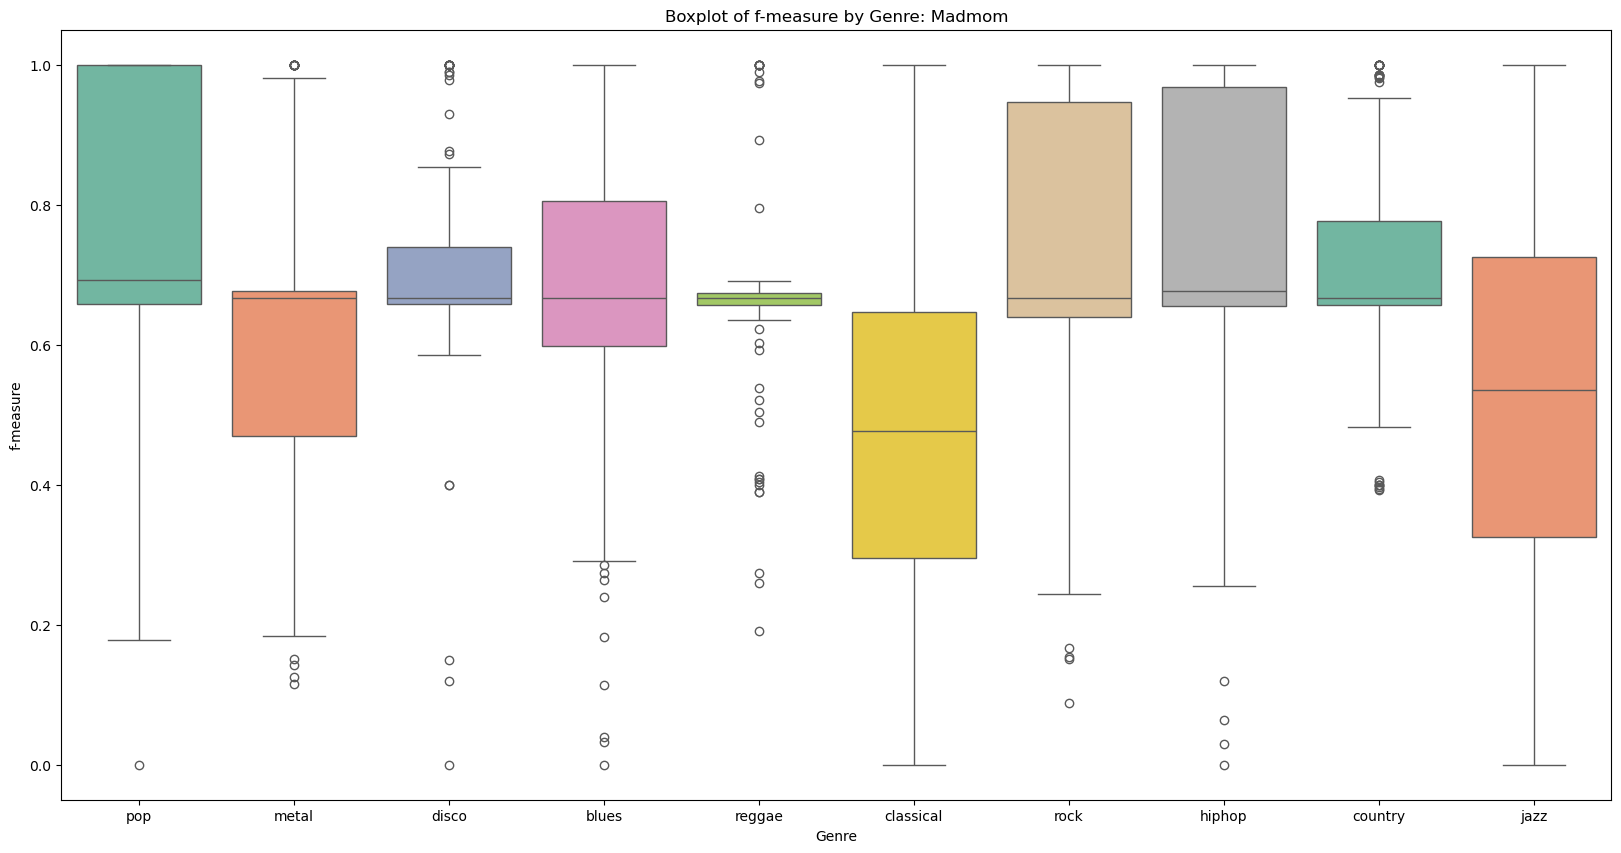

In [48]:
import seaborn as sns

madmom_stats = pd.read_csv('madmom_stats.csv')

palette = sns.color_palette("Set2")

plt.figure(figsize=(20, 10))

sns.boxplot(x='genre', y='f_measure', data=madmom_stats, palette=palette)
plt.title('Boxplot of f-measure by Genre: Madmom')
plt.xlabel('Genre')
plt.ylabel('f-measure')
plt.show()

# Task 2: Beat Tracking and Tempo Estimation with Librosa and the Spectral Flux Envelope

Now for comparison, we can build a similar function to madmom_calculate_beats that instead utilizes the librosa.beat tempo and beat estimation tools:

In [44]:
def librosa_calculate_beats(audio_file_path):
    
    audio, sample_rate = librosa.load(audio_file_path, sr=None)  # Assuming you have librosa installed
    
    fps = 100
    n_fft = 2048
    hop_length = int(librosa.time_to_samples(1./fps, sr=sample_rate))
    n_mels = 80
    fmin = 27.5
    fmax = 17000.
    lag = 2
    max_size = 3
    tightness = 100
    alpha = 0.5

    S = librosa.feature.melspectrogram(y = audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax, n_mels=n_mels)

    spectral_flux = librosa.onset.onset_strength(S=librosa.power_to_db(S, ref=np.max),
                                      sr=sample_rate,
                                      hop_length=hop_length,
                                      lag=lag, max_size=max_size)

    predicted_tempo = librosa.beat.tempo(onset_envelope=spectral_flux, sr=sample_rate,
                               hop_length=hop_length)[0]

    period = (fps * 60./predicted_tempo)
    localscore = librosa.beat.__beat_local_score(spectral_flux, period)
    
    backlink = np.zeros_like(localscore, dtype=int)
    cumulative_score = np.zeros_like(localscore)

    # Search range for previous beat
    window = np.arange(-2 * period, -np.round(period / 2) + 1, dtype=int)

    txwt = -tightness * (np.log(-window / period) ** 2)

    # Are we on the first beat?
    first_beat = True
    for i, score_i in enumerate(localscore):

        # Are we reaching back before time 0?
        z_pad = np.maximum(0, min(-window[0], len(window)))

        # Search over all possible predecessors
        candidates = txwt.copy()
        candidates[z_pad:] = candidates[z_pad:] + cumulative_score[window[z_pad:]]

        # Find the best preceding beat
        beat_location = np.argmax(candidates)

        # Add the local score
        cumulative_score[i] = (1-alpha)*score_i + alpha*candidates[beat_location]

        # Special case the first onset.  Stop if the localscore is small
        if first_beat and score_i < 0.01 * localscore.max():
            backlink[i] = -1
        else:
            backlink[i] = window[beat_location]
            first_beat = False

        # Update the time range
        window = window + 1

    beats = [librosa.beat.__last_beat(cumulative_score)]

    # Reconstruct the beat path from backlinks
    while backlink[beats[-1]] >= 0:
        beats.append(backlink[beats[-1]])

    # Put the beats in ascending order
    # Convert into an array of frame numbers
    beats = np.array(beats[::-1], dtype=int)

    # Discard spurious trailing beats
    beats = librosa.beat.__trim_beats(spectral_flux, beats, trim=True)
    
    # Convert beat times seconds
    beats = librosa.frames_to_time(beats, hop_length=hop_length, sr=sample_rate)
    
    return beats, predicted_tempo     

Finally, here we can call the Librosa algorithm through the evaluate_beat_tracking_algorithm function

In [45]:
evaluate_beat_tracking_algorithm("librosa", algorithm_beats_folder, ground_truth_beats_folder, ground_truth_tempo_folder)

/Users/jeetajmani/miniconda3/envs/first/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/var/folders/hm/gm5bqtd95wbdk6q6k371kn080000gn/T/ipykernel_9876/1492126870.py:23: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  predicted_tempo = librosa.beat.tempo(onset_envelope=spectral_flux, sr=sample_rate,


F-measure for pop.00027.wav: 0.0
Audio File: pop.00027.wav
Algorithm Beats: [ 0.30929705  0.66848073  1.0276644   1.37687075  1.73605442  2.0952381
  2.45442177  2.81360544  3.17278912  3.52199546  3.88117914  4.23038549
  4.59954649  4.95873016  5.30793651  5.65714286  6.01632653  6.36553288
  6.72471655  7.08390023  7.4430839   7.79229025  8.15147392  8.5106576
  8.86984127  9.21904762  9.57823129  9.93741497 10.29659864 10.64580499
 11.00498866 11.36417234 11.72335601 12.07256236 12.43174603 12.79092971
 13.15011338 13.49931973 13.8585034  14.21768707 14.57687075 14.93605442
 15.2952381  15.64444444 16.00362812 16.36281179 16.72199546 17.07120181
 17.43038549 17.77959184 18.13877551 18.49795918 18.85714286 19.20634921
 19.56553288 19.92471655 20.28390023 20.63310658 20.99229025 21.36145125
 21.73061224 22.06984127 22.42902494 22.78820862 23.14739229 23.49659864
 23.84580499 24.20498866 24.56417234 24.92335601 25.28253968 25.63174603
 25.99092971 26.34013605 26.69931973 27.0585034  2

/var/folders/hm/gm5bqtd95wbdk6q6k371kn080000gn/T/ipykernel_9876/2505461848.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre', y='f_measure', data=librosa_stats, palette=palette)
/var/folders/hm/gm5bqtd95wbdk6q6k371kn080000gn/T/ipykernel_9876/2505461848.py:7: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='genre', y='f_measure', data=librosa_stats, palette=palette)


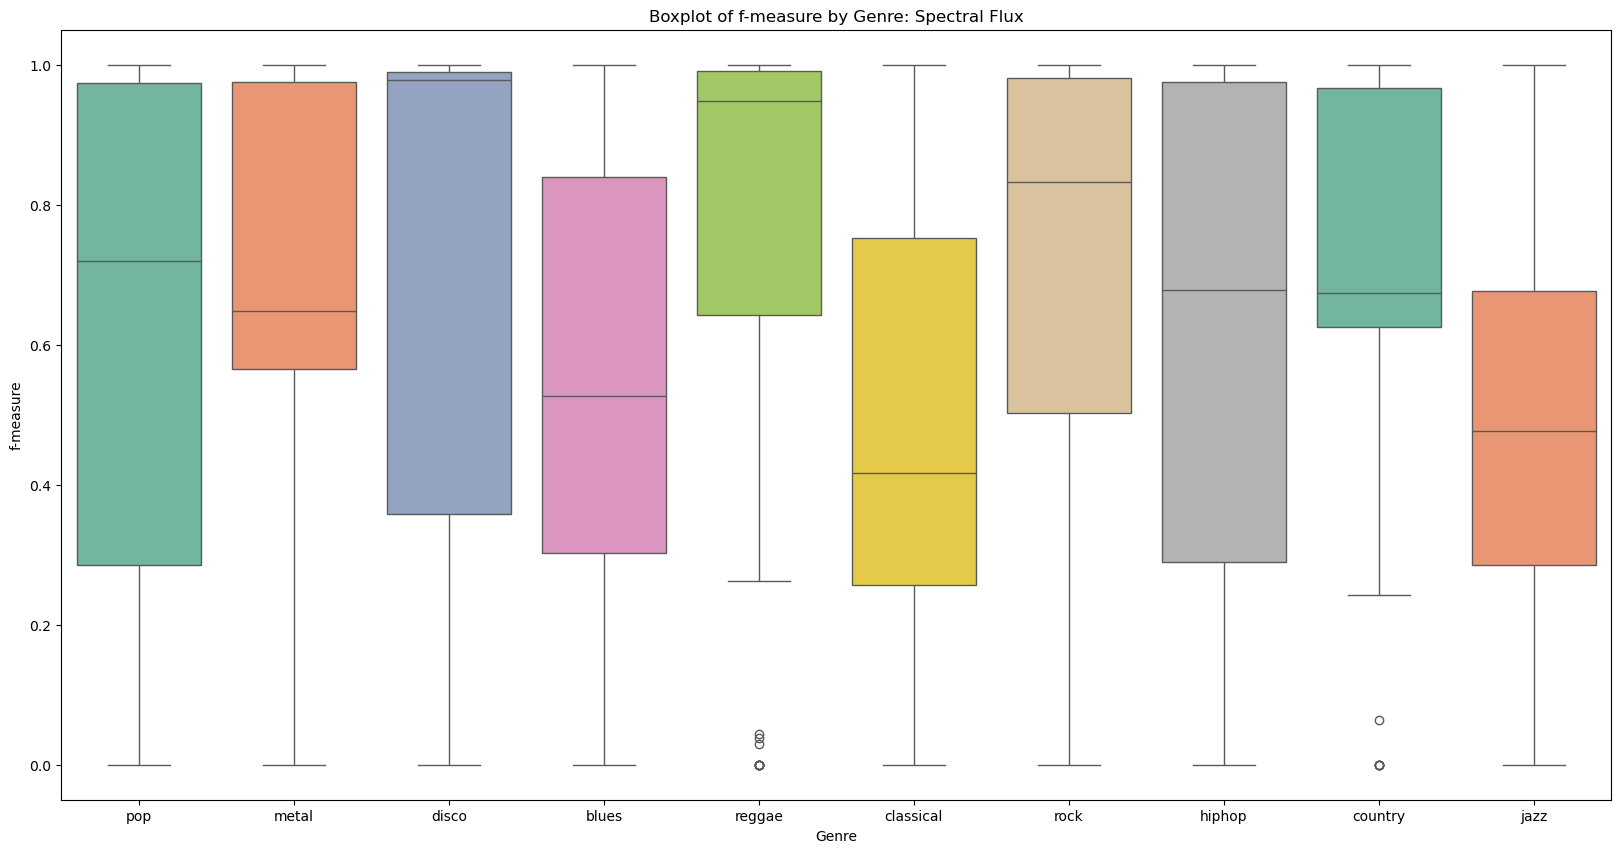

In [47]:
librosa_stats = pd.read_csv('librosa_stats.csv')

palette = sns.color_palette("Set2")

plt.figure(figsize=(20, 10))

sns.boxplot(x='genre', y='f_measure', data=librosa_stats, palette=palette)
plt.title('Boxplot of f-measure by Genre: Spectral Flux')
plt.xlabel('Genre')
plt.ylabel('f-measure')
plt.show()